In [1]:
import numpy as np
import mne
from scipy.signal import welch
import matplotlib.pyplot as plt

In [2]:
# definição do info (MNE)

n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

<Info | 8 non-empty values
 bads: []
 ch_names: F3, Fz, F4, C3, Cz, C4, P3, P4
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>

In [3]:
# Carregamento e organização dos dados de Emily

# Glucamon: 0,35s até 3:20
glucamon_files = [
    '../database/s3/glucamon/OpenBCI-RAW-2023-11-08_13-55-20.txt',
    '../database/s3/glucamon/OpenBCI-RAW-2023-11-08_13-57-31.txt'
]
glucamon_data = [np.loadtxt(f, delimiter=',', skiprows=5, usecols=range(1, 9)) for f in glucamon_files]
glucamon_data_combined = np.vstack(glucamon_data)
data_glucamon = glucamon_data_combined[int(0.35 * sfreq):int(200 * sfreq), :]  # de 0,35s até 3:20 (200s)

# Insulina: Usando todos os dados da pasta de insulina
insulina_files = [
    '../database/s3/insulina/OpenBCI-RAW-2023-10-24_14-19-06.txt',
    '../database/s3/insulina/OpenBCI-RAW-2023-10-24_14-19-27.txt',
    '../database/s3/insulina/OpenBCI-RAW-2023-10-24_14-20-06.txt',
    '../database/s3/insulina/OpenBCI-RAW-2023-10-24_14-21-23.txt',
    '../database/s3/insulina/OpenBCI-RAW-2023-10-24_14-28-10.txt'
]
insulina_data = [np.loadtxt(f, delimiter=',', skiprows=5, usecols=range(1, 9)) for f in insulina_files]
insulina_data_combined = np.vstack(insulina_data)

# Teste: 0s a 9min9s (Emily Teste Final)
teste_final_file = '../database/s3/teste/OpenBCI-RAW-2023-11-24_12-19-35.txt'
teste_final_data = np.loadtxt(teste_final_file, delimiter=',', skiprows=5, usecols=range(1, 9))

# Cortes para o Teste Final
data_teste_basal = teste_final_data[:int(60 * sfreq), :]  # de 0s a 60s (Basal)
data_teste = teste_final_data[int(61 * sfreq):int(549 * sfreq), :]  # de 61s até 9min9s (Teste)

# Criação dos objetos RawArray para MNE
X = {
    'glucamon': mne.io.RawArray(data_glucamon.T, info),
    'insulina': mne.io.RawArray(insulina_data_combined.T, info),
    'teste_basal': mne.io.RawArray(data_teste_basal.T, info),
    'teste': mne.io.RawArray(data_teste.T, info),
}

Creating RawArray with float64 data, n_channels=8, n_times=49913
    Range : 0 ... 49912 =      0.000 ...   199.648 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=366094
    Range : 0 ... 366093 =      0.000 ...  1464.372 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=15000
    Range : 0 ... 14999 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=122000
    Range : 0 ... 121999 =      0.000 ...   487.996 secs
Ready.


In [4]:
# Filtragem dos dados
for key in X:
    X[key].notch_filter(freqs=60)
    X[key].filter(l_freq=4, h_freq=100)
    print(X[key].n_times)
    print(X[key].times)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband e

In [5]:
import sys

sr = 250            
jump = 3
size = sr * jump

# Definir os limites das bandas de frequência
theta_band = (4, 8)
alpha_band = (8, 13)
beta_band = (13, 30)
gamma_band = (30, 100)

total_pc = {}
data_names = ('glucamon', 'insulina', 'teste_basal', 'teste')
datas = [X['glucamon'], X['insulina'], X['teste_basal'], X['teste']]


# Processamento e análise das bandas
for k, data in enumerate(datas):
    results = [0, 0, 0, 0]
    for i in range(0, data.n_times, 250):
        if i + size < data.n_times:
            cut = data.copy().crop(tmin=data.times[i], tmax=data.times[i]+jump)
        else:
            cut = data.copy().crop(tmin=data.times[i], tmax=data.times[-1])
        
        nperseg = 128
        noverlap = nperseg // 2
        cut.set_eeg_reference(ref_channels='average')
        cut = cut.get_data()

        # Média dos 8 eletrodos
        freqs, psd = welch(cut, fs=sfreq, nperseg=nperseg, noverlap=noverlap)
        X_psd = np.average(psd, axis=0)

        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

        bands = [np.sum(X_psd[theta_idxs]), np.sum(X_psd[alpha_idxs]), np.sum(X_psd[beta_idxs]), np.sum(X_psd[gamma_idxs])]
        results[np.argmax(bands)] += 1

    total = sum(results)
    percentages = [round((count / total) * 100, 2) for count in results]
    print(data.__str__())
    total_pc[data_names[k]] = percentages


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
E

/home/vinicius/workspace-rec/venv/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 128 is greater than input length  = 94, using nperseg = 94
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
E

In [8]:
# Função para plotar os gráficos de barras
from matplotlib import rcParams
rcParams['figure.figsize'] = [6., 4.]

def plot_bar(x):
    colors = ('orange', 'green', 'blue', 'purple')
    bars = plt.bar(('theta', 'alpha', 'beta', 'gamma'), x, color=colors)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
    plt.title('Porcentagem da potência em cada banda de frequência')
    plt.xlabel('Banda de Frequência')
    plt.ylabel('Porcentagem durante a atividade')
    plt.show() 

# Aplicando os valores das porcentagens obtidas na função do grafico

Glucamon


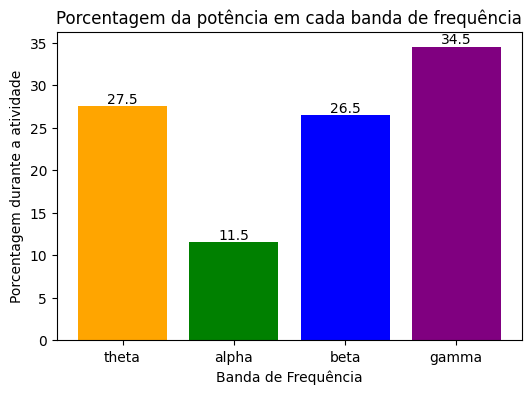

Insulina


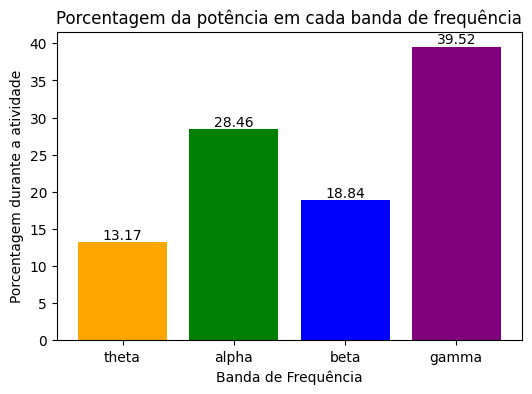

Teste


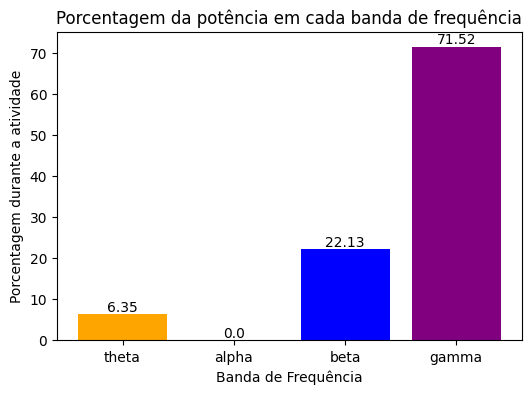

In [10]:
# Plots dos resultados
print('Glucamon')
plot_bar(total_pc['glucamon'])
print('Insulina')
plot_bar(total_pc['insulina'])
print('Teste')
plot_bar(total_pc['teste'])

In [ ]:
#Na Tarefa 1 utilizei o metodo set_eeg_reference para aplicar um filtro espacial.
#A cada iteração, os dados foram cortados em janelas de 5 segundos e transformados no dominio da frequência usando a função welch.
#A potencia foi calculada em diferentes bandas de frequencia, e o filtro espacial foi aplicado nesses
#segmentos para garantir uma analise mais precisa.

#Na Tarefa 2 apos o calculo das porcentagens gerais de cada banda de frequnecia ao longo do experimento, fiz uma
#analise mais detalhada focada em momentos especificos que podem ter maior relevância para as bandas Beta e Gamma, que
#são relacionadas à atenção e foco. A partir dessas análises detalhadas, podemos ver como o Beta e Gamma se comportam ao
#longo do tempo, principalmente em momentos críticos da aula. Isso permite observar em que momentos específicos do experimento
#ha predominancia dessas bandas, o que pode indicar um maior nível de concentração.